# Medicina Personalizada - Redefinindo o Tratamento de Câncer

Muito tem sido dito durante os últimos anos sobre como a medicina de
precisão e, mais concretamente, como o teste genético, vai provocar disrupção no
tratamento de doenças como o câncer.

Mas isso ainda está acontecendo apenas parcialmente devido à enorme
quantidade de trabalho manual ainda necessário. Neste projeto, tentaremos levar
a medicina personalizada ao seu potencial máximo.

Uma vez sequenciado, um tumor cancerígeno pode ter milhares de
mutações genéticas. O desafio é distinguir as mutações que contribuem para o
crescimento do tumor das mutações.

Atualmente, esta interpretação de mutações genéticas está sendo feita
manualmente. Esta é uma tarefa muito demorada, onde um patologista clínico tem
que revisar manualmente e classificar cada mutação genética com base em
evidências da literatura clínica baseada em texto.

Para este projeto, o MSKCC (Memorial Sloan Kettering Cancer Center) está
disponibilizando uma base de conhecimento anotada por especialistas, onde
pesquisadores e oncologistas de nível mundial anotaram manualmente milhares
de mutações.

Neste projeto, você vai desenvolver um algoritmo de Aprendizado de
Máquina que, usando essa base de conhecimento como uma linha de base,
classifica automaticamente as variações genéticas.

O dataset completo pode ser encontrado em:
https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

Este projeto faz parte do curso Machine Learning da Data Science Academy

#### Preparando as bibliotecas a serem utilizadas

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from keras.models import Sequential,Input,Model, load_model
from keras.metrics import AUC
from keras.layers import Dense
from keras.utils import plot_model,to_categorical
from keras.optimizers import SGD

from sklearn.model_selection import train_test_split
import tensorflow as tf
import re
import string
import scipy.sparse as sp

from ipynb.fs.full.Funcoes import *

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import pickle
from collections import Counter
from functools import reduce
from wordcloud import WordCloud

In [2]:
convert__df

<function ipynb.fs.full.Funcoes.convert__df(read)>

Both, training and test, data sets are provided via two different files. One (training/test_variants) provides the information about the genetic mutations, whereas the other (training/test_text) provides the clinical evidence (text) that our human experts used to classify the genetic mutations. Both are linked via the ID field.

Therefore the genetic mutation (row) with ID=15 in the file training_variants, was classified using the clinical evidence (text) from the row with ID=15 in the file training_text

* __training_variants__ - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)
* **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)
* __test_variants__ - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations)
* **test_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

In [23]:
test_text = "./data_files/test_text"
test_variants = "./data_files/test_variants"
training_text = "./data_files/training_text"
training_variants = "./data_files/training_variants"

#### Lendo os arquivos de entrada e convertendo os dados lidos em dataframes

In [26]:
df_test_text = convert__df(test_text)
df_test_variants = convert_variant_df(test_variants)
df_training_text = convert__df(training_text)
df_training_variants = convert_variant_df(training_variants)


#### Função para exploração inicial de dados

In [28]:
df_training = df_training_text.merge(right=df_training_variants,on = 'ID').drop(columns = "ID")
df_test = df_test_text.merge(right=df_test_variants,on = 'ID').drop(columns = "ID")
df_training

,Text,Gene,Variation,Class
0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4
...,...,...,...,...
3316,Introduction Myelodysplastic syndromes (MDS) ...,RUNX1,D171N,4
3317,Introduction Myelodysplastic syndromes (MDS) ...,RUNX1,A122*,1
3318,The Runt-related transcription factor 1 gene (...,RUNX1,Fusions,1
3319,The RUNX1/AML1 gene is the most frequent targe...,RUNX1,R80C,4


In [29]:
df_test

,Text,Gene,Variation
0,2. This mutation resulted in a myeloproliferat...,ACSL4,R570S
1,Abstract The Large Tumor Suppressor 1 (LATS1)...,NAGLU,P521L
2,Vascular endothelial growth factor receptor (V...,PAH,L333F
3,Inflammatory myofibroblastic tumor (IMT) is a ...,ING1,A148D
4,Abstract Retinoblastoma is a pediatric retina...,TMEM216,G77A
...,...,...,...
5663,The realization in the late 1970s that RAS har...,SLC46A1,R113S
5664,Hemizygous deletions are common molecular abno...,FOXC1,L130F
5665,All most R267W of has with to SMARTpool invest...,GSS,R267W
5666,Abstract Blood samples from 125 unrelated fami...,CTSK,G79E


In [30]:
#Checando os dados iniciais
explore_describe(df_training)

,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,Text,object,0,0.0%,1921,-,-,-,-,-,-,-,-,-,-
1,Gene,object,0,0.0%,264,-,-,-,-,-,-,-,-,-,-
2,Variation,object,0,0.0%,2996,-,-,-,-,-,-,-,-,-,-
3,Class,object,0,0.0%,9,-,-,-,-,-,-,-,-,-,-


In [31]:
explore_describe(df_test)

,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,Text,object,0,0.0%,5611,-,-,-,-,-,-,-,-,-,-
1,Gene,object,0,0.0%,1397,-,-,-,-,-,-,-,-,-,-
2,Variation,object,0,0.0%,5628,-,-,-,-,-,-,-,-,-,-


#### Vamos salvar os df no formato csv para facilitar o carregamento posterior

In [ ]:
df_training.to_csv("df_training.csv")
df_test.to_csv("df_test.csv")

#### Vamos importar os arquivos csv

In [2]:
df_training = pd.read_csv("df_training.csv")
df_test = pd.read_csv("df_test.csv")

## Vamos criar a classe CORPUS que receberá os métodos e atributos para a manipulação dos dados

class CORPUS():
    def __init__(self,dataset,col_text = "Text"):
        self.dataset = dataset.copy()
        self.textos = dataset[col_text]
        self.textos_filtrados = pd.Series()
        self.listagem = set()
        self.corpus = []
        self.bag_of_words = []
        self.N = 0
        self.tf = []
        self.df = {}
        self.idf = {}
        self.tfidf = []

    # Função para remoção de qualquer caracter não ASCII 
    def removeNoAscii(self):
        self.textos_filtrados = self.textos.map(lambda x: "".join(i for i in x if ord(i) < 128))
        return self
    
    # Função para executar o processo de transforção em corpus
    def executa_corpunization(self):
        self.corpus = [self.corpunization(texto) for texto in self.textos_filtrados]
    
    #Função para criar o corpus
    def corpunization(self,text):
        #Removendo a pontuação e tokenizando
        nopunct_token = nltk.tokenize.regexp_tokenize(text.lower(),"[\w']+")

        #Removendo stopwords
        token_no_stopwords = [word for word in nopunct_token if word not in nltk.corpus.stopwords.words('english')]

        #Stemming
        #cooking -> cook
        token_stem = [nltk.stem.PorterStemmer().stem(token) for token in token_no_stopwords]

        #Lemmatization
        #mice -> mouse
        self.corpus = [nltk.stem.WordNetLemmatizer().lemmatize(token) for token in token_stem]
        return(self)
    
    #Cria a listagem de todas as palvras
    def cria_listagem_palavras(self, *another_corpus):
        count = 0
        for var in another_corpus:
            count += 1
            
        if(count != 0):
            #another_corpus é passado como tupla
            corpus_listagem = self.corpus + another_corpus[0]
        else:
            corpus_listagem = self.corpus
            
        for i in corpus_listagem:
            self.listagem = self.listagem.union(set(i))
        return(self)

    #Função para contrar a quantidade de cada palavra no corpus
    def conta_palavras_corpus(self):
        self.bag_of_words = [dict(Counter(i)) for i in self.corpus]
        self.N = len(self.bag_of_words)
        return self
    
    #Função para calcular o df (a frequencia de uma palavra no documento)
    def df_dict(self):
        self.df = {token: sum([token in doc.keys() for doc in self.bag_of_words]) for token in self.listagem}
        return self
        
    #Função para calcular o tf e o idf de cada palvra da coleção de documentos
    def calcula_tf_e_idf(self,*CORPUS_TREINO):
        count = 0
        for var in CORPUS_TREINO:
            count += 1
            
        if(count != 0):
            bag = CORPUS_TREINO.bag_of_words
        else:
            bag = self.bag_of_words
            
        #Calculando a frequencia do termo para cada documento
        self.tf = [{key:t/sum(documento.values()) for key,t in documento.items()} for documento in bag]
        self.idf = {chave: np.log(N/(valor+1))  for chave,valor in self.df.items()}
        return self
    
    #Função para o cálculo do TF-IDF
    def tf_idf(self):
        self.tfidf = [{chave: tf*self.idf[chave] for chave,tf in doc.items()} for doc in self.tf]
        return self
    
    #Função para criar a nuvem de palavras, baseado na frequencia das palvras no documento
    def word_cloud(self,classe,dataset):
        indices = self.dataset[self.dataset["Class"] == classe].index
        bag_words_filtrada = [self.bag_of_words[i] for i in indices]
        dicionario_classe = reduce(lambda x,y: Counter(x) + Counter(y), bag_words_filtrada)
        wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate_from_frequencies(dicionario_classe)
        return(wordcloud)

    #Vamos criar uma nuvem de palavra baseado no TF_IDF
    def word_cloud_tfidf(self,classe):
        indices = self.dataset[self.dataset["Class"] == classe].index
        lista_tfidf_filtrada = [self.tfidf[i] for i in indices]
        dicionario_classe_tf_idf = reduce(lambda x, y: dict((chave, valor + y[chave]) if chave in y.keys() else (chave, valor) for chave, valor in x.items()), tfidf)
        wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate_from_frequencies(dicionario_classe_tf_idf)
        return(wordcloud)
    
    #Função para plotar a word cloud desejada
    def plota_wordcloud(self,func):
        fig = plt.figure(figsize=(20,10))
        for i in range(1,10):
            ax = fig.add_subplot(3,3,i)
            ax.imshow(func(i))
            ax.set_title(str(i))
            plt.axis("off")
        plt.show()

In [32]:
# Primeiramente, vamos criar a frequencia de cada termo
textos_treino = df_training.Text
textos_test = df_test.Text

In [34]:
textos_treino_limpa = textos_treino.map(lambda x: removeNoAscii(x))
textos_teste_limpa = textos_test.map(lambda x: removeNoAscii(x))

In [36]:
textos_treino_limpa.head()

0    Cyclin-dependent kinases (CDKs) regulate a var...
1     Abstract Background  Non-small cell lung canc...
2     Abstract Background  Non-small cell lung canc...
3    Recent evidence has demonstrated that acquired...
4    Oncogenic mutations in the monomeric Casitas B...
Name: Text, dtype: object

#### Criando gerando o CORPUS para tratamento dos dados

In [8]:
#Removendo a pontuação, stopwords, realizando stemming e lemmatization (essa célula pode demorar algumas horas para ser executada)
treino_corpus = [corpusnization(texto) for texto in textos_treino_limpa]
teste_corpus = [corpusnization(texto) for texto in textos_teste_limpa]

In [9]:
#Armazenando os corpus (como a célula acima demora algumas horas, será necessário salvar os dados)
with open('treino_corpus.pkl', 'wb') as f:
        pickle.dump(treino_corpus, f)
with open('teste_corpus.pkl', 'wb') as f:
        pickle.dump(teste_corpus, f)        

## Carregando os dataframe e os corpus

In [2]:
#Carregando novamente os dados. Por demorar para realizar a função corpusnization para tanto os dados de treino quanto os dados de teste, 
#criamos um checkpoint aqui para dar continuidade ao trabalho mais rapidamente

with open('teste_corpus.pkl', 'rb') as f:
       teste_corpus = pickle.load(f)
        
with open('treino_corpus.pkl', 'rb') as f:
        treino_corpus = pickle.load(f)
        
df_training = pd.read_csv("df_training.csv")
df_test = pd.read_csv("df_test.csv")

#### Verificando a quantidade de classes no dataset

Nota-se que a quantidade de classes está desbalanceada

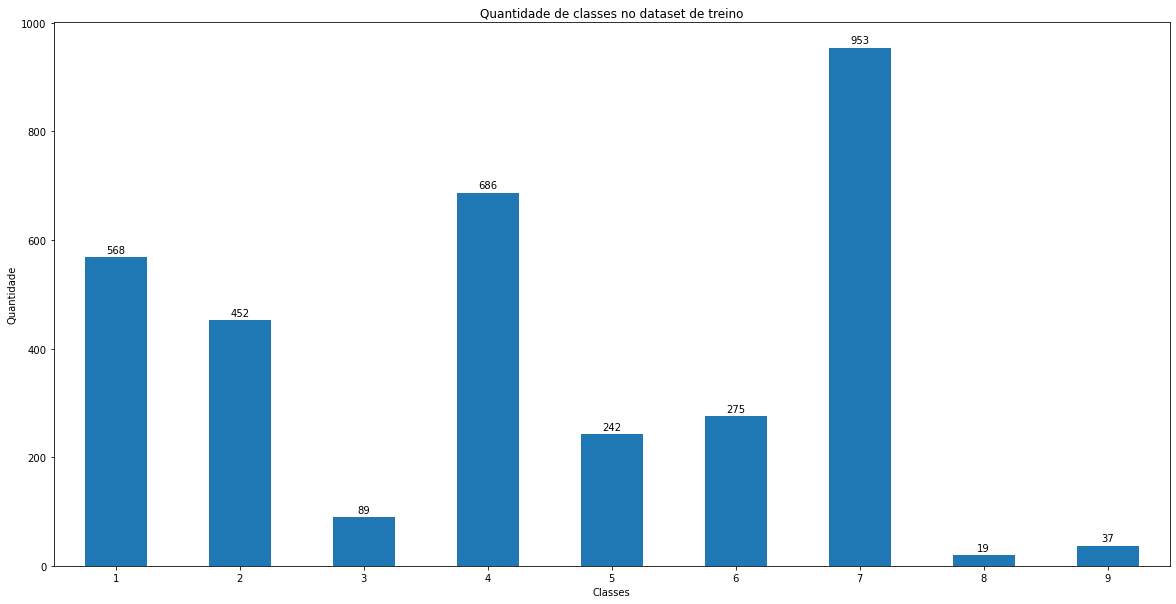

In [3]:
plt.figure(figsize=(20,10))
ax = df_training["Class"].value_counts().sort_index().plot(kind = "bar")
plt.xticks(rotation = 0)
plt.xlabel("Classes")
plt.ylabel("Quantidade")
plt.title("Quantidade de classes no dataset de treino")
rects = ax.patches

for rect, label in zip(rects, list(df_training["Class"].value_counts().sort_index())):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

## Criando dicionário de palavras

In [5]:
#Usando as palavras dos dados de teste, para que não haja problemas na hora dos testes
listagem = cria_listagem_palavras(treino_corpus+teste_corpus)

In [23]:
pickle.dump(listagem,open("listagem.pkl","wb"))

In [37]:
dicionario = cria_dicionario_palavras(listagem)

In [39]:
pickle.dump(dicionario,open("dicionario.pkl","wb"))

## Criação da Bag of Words

In [9]:
bag_words_corpus = [conta_palavras_corpus(i) for i in treino_corpus]
N = len(bag_words_corpus)

In [30]:
pickle.dump(bag_words_corpus,open("bag_of_words.plk","wb"))

## Definindo a frequencia do documento para cada palavra

In [11]:
DocFreq = df_dict(listagem,bag_words_corpus)

In [25]:
pickle.dump(DocFreq,open("DocFreq.plk","wb"))

## TF-IDF

Vamos criar o tf-idf para a base de dados de treino, para que possamos criar nosso dataset para passar ao modelo

In [13]:
tf_treino,idf_treino = calcula_tf_e_idf(bag_words_corpus, DocFreq,N)

In [26]:
pickle.dump(tf_treino,open("tf_treino.plk","wb"))
pickle.dump(idf_treino,open("idf_treino.plk","wb"))

In [15]:
tfidf = tf_idf(tf_treino,idf_treino)

In [27]:
pickle.dump(tfidf,open("tfidf.plk","wb"))

#### Criando outro checkpoint e abrindo os arquivos trabalhados

In [2]:
tfidf = pickle.load(open("tfidf.plk","rb"))
tf_treino = pickle.load(open("tf_treino.plk","rb"))
idf_treino = pickle.load(open("idf_treino.plk","rb"))
DocFreq = pickle.load(open("DocFreq.plk","rb"))
bag_words_corpus = pickle.load(open("bag_of_words.plk","rb"))
listagem = pickle.load(open("listagem.pkl","rb"))
dicionario = pickle.load(open("dicionario.pkl","rb"))

df_training = pd.read_csv("df_training.csv")
df_test = pd.read_csv("df_test.csv")

N = len(bag_words_corpus)

Existe um alto volume de palavras com pouquissimas repetições

In [25]:
#plt.figure(figsize = (15,8))
#pd.Series({i: len([key for key,valor in qtd_palavras_corpus.items() if valor <= i]) for i in range(0,20)}).plot(kind = "line")
#plt.title("Volume de repetições de palavras no documento de treino")
#plt.xlabel("Volume de repetições")
#plt.ylabel("Quantidade de palavras")
#plt.show()

## Word Cloud

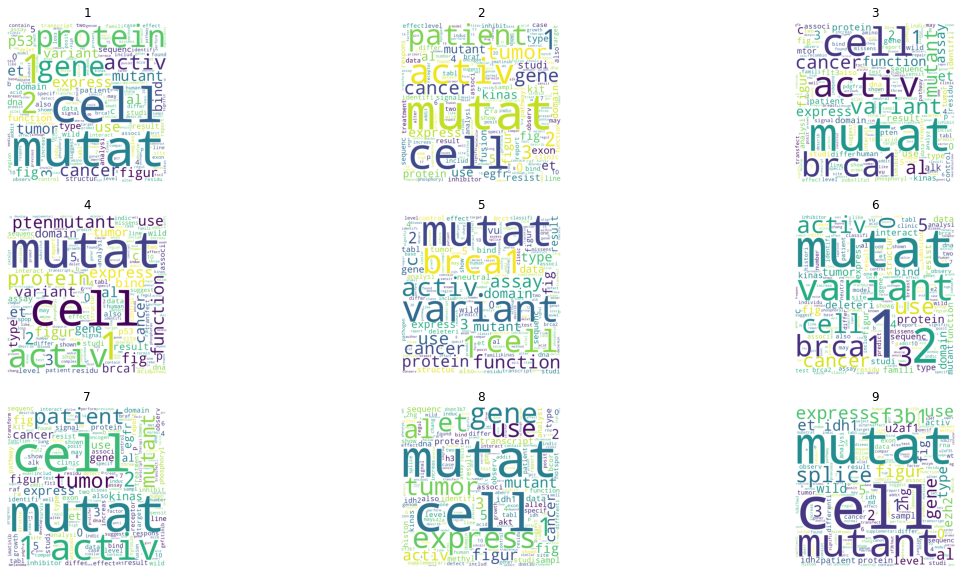

In [20]:
plota_wordcloud(word_cloud_plot,df_training,bag_words_corpus)

As palavras:
* mutat;
* cell;
* active
* números isolados;

parecem estar em todos as classes 

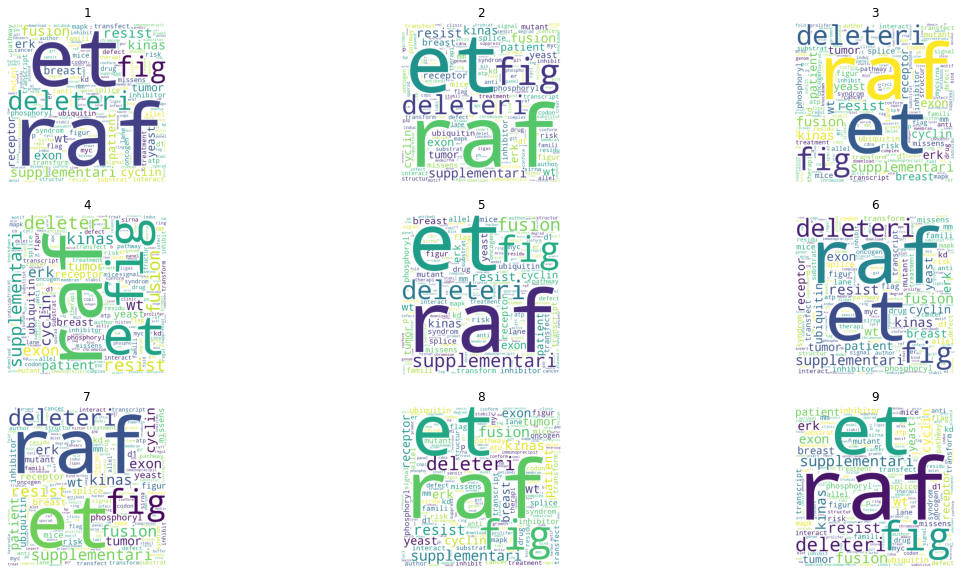

In [18]:
#Vamos ver se há diferença na nuvem de palavras usando o conceito de TF-IDF
plota_wordcloud(word_cloud_plot_tfidf,df_training,bag_words_corpus)

Quando usamos tf-idf, as palavras que aparecem tm toda são:
* fig;
* et;
* raf.

## Vamos criar um modelo base

In [5]:
#Dividindo os dados de treino e teste, para verificar o quao bom nosso modelo está
x_train, x_test, y_train, y_test = train_test_split(df_training.drop(columns = "Class"), df_training["Class"], test_size=0.3, random_state=42)
x_train,x_valid,y_train,y_valid =  train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [6]:
X = matriz_esparca(dicionario,tfidf,N)

In [8]:
#Variáveis de entrada
X_train = convert_matriz_esparca_tfSparce(X[x_train.index,:])
X_valid = convert_matriz_esparca_tfSparce(X[x_valid.index,:])
X_test =  convert_matriz_esparca_tfSparce(X[x_test.index,:])

In [9]:
#Classes (vamos colocar as classes de 0 a 8)
Y = df_training.Class.apply(lambda x: x-1).to_numpy()
Y_train = to_categorical(Y[x_train.index])
Y_valid = to_categorical(Y[x_valid.index])
Y_test = to_categorical(Y[x_test.index])

# Vamos verificar, se os dados Gene e Variation encontram-se nos respectivos textos

In [10]:
vetor_gene = []
vetor_variation = []
for (i,[gene,variation]) in enumerate(zip(df_training["Gene"],df_training["Variation"])):
    try:
        if(X[i,dicionario[gene.lower()]]>0):
            vetor_gene.append(True)
        else:
            vetor_gene.append(False)
    except:
        vetor_gene.append(False)
    
    try:
        if(X[i,dicionario[variation.lower()]]>0):
            vetor_variation.append(True)
        else:
            vetor_variation.append(False)
    except:
        vetor_variation.append(False)

Alguns documentos não possuem a informação de gene e variation, conforme está no dataset

In [11]:
pd.Series(vetor_variation).value_counts()

True     1817
False    1504
dtype: int64

In [12]:
pd.Series(vetor_gene).value_counts()

True     2985
False     336
dtype: int64

## Criando a rede neural para o treinamento do modelo 1

In [13]:
X_train.shape

TensorShape([1859, 164493])

In [38]:
#Criando o modelo para receber os dados de entrada
camada_entrada = Input(shape = (X.shape[1],), sparse=True,name = "Camada_Entrada")
primeira_camada_oculta = Dense(1000,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_1")(camada_entrada)
segunda_camada_oculta = Dense(100,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_2")(primeira_camada_oculta)
camada_saida = Dense(9,activation = 'softmax',kernel_initializer = 'uniform',name = "Camada_de_Saida")(segunda_camada_oculta)

modelo1 = Model(inputs = [camada_entrada], outputs = [camada_saida])
#modelo1.add(Dense(100,activation = 'relu',kernel_initializer = 'uniform'))
#modelo1.add(Dense(9,activation = 'softmax',kernel_initializer = 'uniform'))

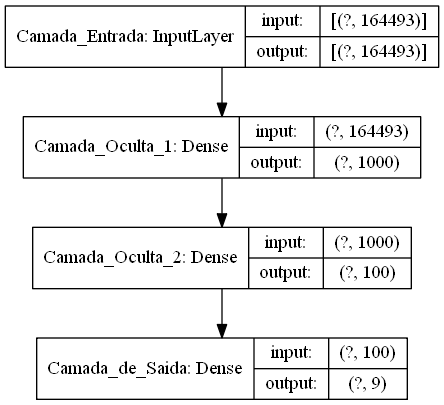

In [39]:
#Visualizando o primeiro modelo
plot_model(modelo1,show_shapes=True)

In [42]:
modelo1.compile(loss = 'categorical_crossentropy', 
                optimizer = SGD(lr = 0.05, momentum = 0.9, nesterov = True), 
                metrics = ['categorical_accuracy',AUC()])

In [43]:
modelo1.fit(X_train,Y_train,epochs=150,validation_data = (X_valid,Y_valid),batch_size=20,shuffle=True)

Epoch 1/150
93/93 [==============================] - 61s 654ms/step - loss: 1.8388 - categorical_accuracy: 0.2921 - auc_9: 0.7562 - val_loss: 1.8526 - val_categorical_accuracy: 0.2731 - val_auc_9: 0.7549
Epoch 2/150
93/93 [==============================] - 59s 639ms/step - loss: 1.8438 - categorical_accuracy: 0.2786 - auc_9: 0.7547 - val_loss: 1.8525 - val_categorical_accuracy: 0.2731 - val_auc_9: 0.7552
Epoch 3/150
93/93 [==============================] - 59s 639ms/step - loss: 1.8349 - categorical_accuracy: 0.2829 - auc_9: 0.7575 - val_loss: 1.8698 - val_categorical_accuracy: 0.2731 - val_auc_9: 0.7597
Epoch 4/150
93/93 [==============================] - 60s 640ms/step - loss: 1.8392 - categorical_accuracy: 0.2894 - auc_9: 0.7566 - val_loss: 1.8510 - val_categorical_accuracy: 0.2731 - val_auc_9: 0.7664
Epoch 5/150
93/93 [==============================] - 60s 643ms/step - loss: 1.8342 - categorical_accuracy: 0.2899 - auc_9: 0.7580 - val_loss: 1.8534 - val_categorical_accuracy: 0.2731 

In [50]:
modelo1.save("./modelos/modelo1.h5")

## Criando outro check point

In [ ]:
modelo1 = load_model("./modelos/modelo1.h5")load_model